#### Regression coefficient analysis

In [45]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
import scipy.optimize as optimize 
from scipy.optimize import curve_fit
from scipy import stats
from scipy.stats import linregress

from IPython.display import display, HTML
import sys
import re
import glob

sys.path.insert(1, '/Users/nickkeesey/Desktop/learning-dynamics-behavior/src/utils')
import behavior_utils as bu
import array_utils as au
import load_utils as lu

In [46]:
# NOTE: Exclude auto_water choices, set df_trial.auto_waterR | df_trial.auto_waterL == np.nan, need a way to balance out block length elongation 

# choice_history = df_trial['animal_response'].values
# choice_history[choice_history == 2] = np.nan
# reward_history = (df_trial.rewarded_historyL | df_trial.rewarded_historyR | 
#                     df_trial.auto_waterR | df_trial.auto_waterL 
#                     & (df_trial.animal_response != 2)
#                     ).astype(int).values

In [47]:
# Load in session DataFrame
folder = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/filtered_data_20241107.csv'
session_df = pd.read_csv(folder)

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_60450/1997540078.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  session_df = pd.read_csv(folder)


In [48]:
# Load in combined regression trials DataFrame
combined_df = lu.process_csv_files('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/temp_regression_trials/')

In [49]:
combined_df

,trial_back,RewC,UnrC,subject_id,session_date
0,1,2.389875,1.055672,740610,2024-09-12
1,2,1.136916,0.459166,740610,2024-09-12
2,3,0.707973,0.154371,740610,2024-09-12
3,4,0.452184,-0.221890,740610,2024-09-12
4,5,0.043466,-0.047633,740610,2024-09-12
...,...,...,...,...,...
80830,11,0.065162,0.094580,721403,2024-07-15
80831,12,0.956263,-0.562575,721403,2024-07-15
80832,13,0.826524,0.962326,721403,2024-07-15
80833,14,-1.043162,0.098873,721403,2024-07-15


<Axes: xlabel='trial_back', ylabel='RewC'>

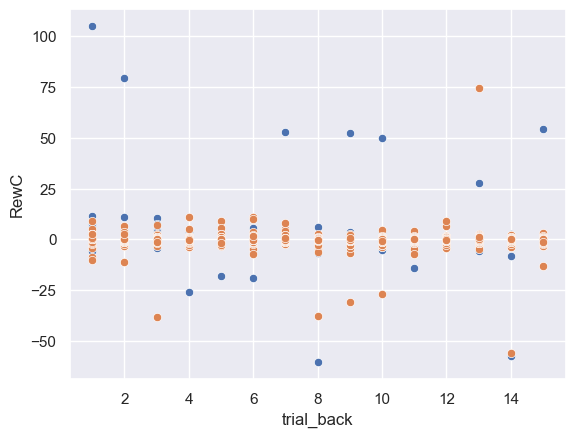

In [50]:
sns.scatterplot(combined_df, x='trial_back', y='RewC')
sns.scatterplot(combined_df, x='trial_back', y='UnrC')

#### Preprocesses

In [79]:
def remove_outliers(df, rew_iqr_factor=5, unr_iqr_factor=5):
    """
    Removes outliers from the dataframe based on the IQR of regression coefficient columns
    
    Params: 
    df (pandas.DataFrame): The input dataframe
    rew_iqr_factor (float): Factor for determining RewC outliers
    unr_iqr_factor (float): Factor for determining UnrC outliers 
    
    Returns:
    pandas.DataFrame: The filtered dataframe with outliers removed
    """
    # Calculate the IQR for RewC and UnrC
    rew_q1 = df['RewC'].quantile(0.25)
    rew_q3 = df['RewC'].quantile(0.75)
    rew_iqr = rew_q3 - rew_q1
    
    unr_q1 = df['UnrC'].quantile(0.25)
    unr_q3 = df['UnrC'].quantile(0.75)
    unr_iqr = unr_q3 - unr_q1
    
    # Calculate the upper and lower bounds for outliers
    rew_lower = rew_q1 - rew_iqr_factor * rew_iqr
    rew_upper = rew_q3 + rew_iqr_factor * rew_iqr
    
    unr_lower = unr_q1 - unr_iqr_factor * unr_iqr
    unr_upper = unr_q3 + unr_iqr_factor * unr_iqr
    
    # Filter the dataframe based on the outlier bounds
    filtered_df = df[
        (df['RewC'] >= rew_lower) & (df['RewC'] <= rew_upper) &
        (df['UnrC'] >= unr_lower) & (df['UnrC'] <= unr_upper)
    ]
    
    
    return filtered_df

def remove_incompletes(df):
    """
    Remove subject_id/session_date pairs with less than full number of trial_backs

    Params:
    df (DataFrame): Input DataFrame

    Returns:
    DataFrame: DataFrame with only complete sessions
    """ 

    # Group by subject_id and session_date, count unique trial_back values
    session_counts = df.groupby(['subject_id', 'session_date'])['trial_back'].nunique()

    # Filter for only complete sessions (15)
    complete_sessions = session_counts[session_counts == 15].index.to_frame(index=False)

    # Merge back to only get completed session rows
    filtered_df = df.merge(
        complete_sessions, 
        on=['subject_id', 'session_date'],
        how='inner'
        )

    return filtered_df

In [80]:
filtered_df = remove_outliers(combined_df)

filtered_comp_df = remove_incompletes(filtered_df)

filtered_comp_df

,trial_back,RewC,UnrC,subject_id,session_date
0,1,1.383518,0.872478,699364,2024-02-29
1,2,0.905521,0.206796,699364,2024-02-29
2,3,0.739371,0.049090,699364,2024-02-29
3,4,0.511669,-0.141652,699364,2024-02-29
4,5,0.283563,0.214034,699364,2024-02-29
...,...,...,...,...,...
66310,11,0.028812,-0.033161,680398,2023-09-01
66311,12,0.227268,-0.036060,680398,2023-09-01
66312,13,0.240951,0.006172,680398,2023-09-01
66313,14,-0.018878,-0.032305,680398,2023-09-01


In [ ]:
def sliding_window(df, window_size):
    """
    Sliding window concatenation of RewC and UnrC values across trial_back 
    """

    # Group by subject_id and session_date
    grouped = df.groupby(['subject_id', 'session_date'])

    # Loop through each group
    for name, group in grouped:
        # Get trial back values
        trial_backs = group['trial_back'].values

        # Create a new DataFrame with the sliding window values
        for i in range(len(trial_backs) - window_size + 1):
            window_data = group.iloc[i:i+window_size]
            yield window_data


<Axes: xlabel='trial_back', ylabel='RewC'>

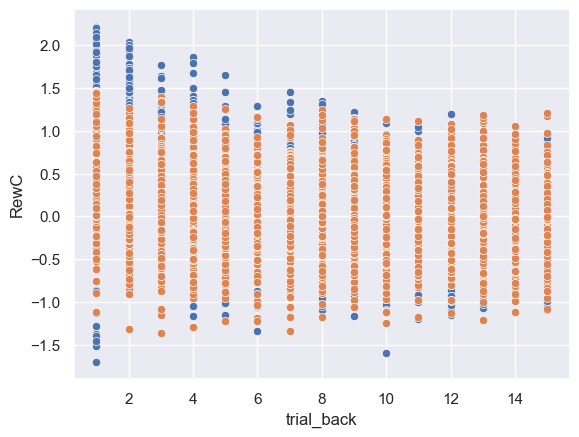

In [81]:
sns.scatterplot(filtered_comp_df, x='trial_back', y='RewC')
sns.scatterplot(filtered_comp_df, x='trial_back', y='UnrC')

In [57]:
def average_across_sessions(df, n_sessions):
    """
    Average RewC and UnrC across every n sessions for each subject,
    using the maximum number of divisible sessions
    
    Params: 
    df (DataFrame): Input dataframe with columns: trial_back, RewC, UnrC, subject_id, session_date
    
    Returns:
    processed_subjects (DataFrame): Averaged dataframe with RewC and UnrC values aggregated across sets of 3 sessions
    """
    # Group sessions by subject_id and sort by session_date
    df_sorted = df.sort_values(['subject_id', 'session_date'])

    processed_subjects = []
    
    # Process each subject
    for subject, subject_data in df_sorted.groupby('subject_id'):
        # Find number of sessions for each subject 
        total_sessions = subject_data['session_date'].nunique()
        
        # Skip subjects with fewer than n sessions
        if total_sessions < n_sessions:
            continue
        
        # Find number of n-session sets
        num_sets = total_sessions // n_sessions
        
        subject_processed = []
        
        # Iterate through sets of n sessions
        for set_num in range(num_sets):
            # Select the subset of data for this n-session set
            start_index = set_num * n_sessions
            end_index = start_index + n_sessions
            
            # Get the sessions for this subset
            subset_sessions = subject_data['session_date'].unique()[start_index:end_index]
            
            # Filter data for these specific sessions
            subset_data = subject_data[subject_data['session_date'].isin(subset_sessions)].copy()
            
            # Average RewC and UnrC for each trial_back
            averaged_subset = subset_data.groupby('trial_back').agg({
                'RewC': 'mean',
                'UnrC': 'mean'
            }).reset_index()
            
            # Add subject and set information
            averaged_subset['subject_id'] = subject
            averaged_subset['session_group'] = set_num
            
            subject_processed.append(averaged_subset)
        
        # Combine sets for this subject
        if subject_processed:
            processed_subjects.append(pd.concat(subject_processed))
    
    # Combine data for all subjects
    if processed_subjects:
        return pd.concat(processed_subjects)[['subject_id', 'session_group', 'trial_back', 'RewC', 'UnrC']]
    else:
        return pd.DataFrame(columns=['subject_id', 'session_group', 'trial_back', 'RewC', 'UnrC'])


In [59]:
# Create wrapper function to remove incomplete sessions from outlier removal process

def compare_session_group_var(df, n_sessions_list):
    variance_results = []

    for n_sessions in n_sessions_list:
        # Get averaged data for current n_session
        processed_data = average_across_sessions(df, n_sessions)

        # Calculate variance for RewC and UnrC across trial_back for each subject
        subject_variances = processed_data.groupby('subject_id').agg({
            'RewC': 'var',
            'UnrC': 'var'
        }).reset_index()

        # Add info for each n_session
        subject_variances['n_sessions'] = n_sessions

        variance_results.append(subject_variances)

    # Combine results for all n_session values
    return pd.concat(variance_results)

In [60]:
n_sessions_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

variance_comparison = compare_session_group_var(filtered_comp_df, n_sessions_list)

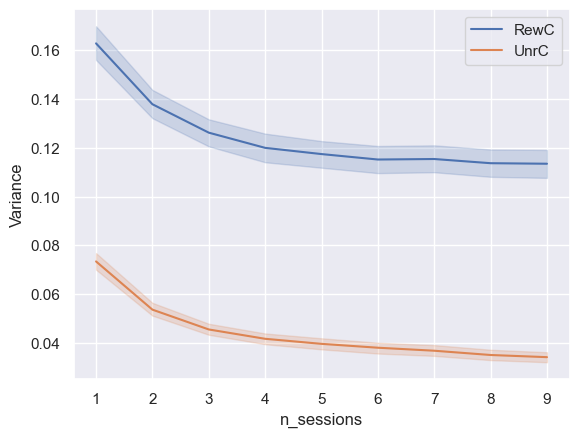

In [62]:
fig, ax = plt.subplots()


sns.lineplot(variance_comparison, x='n_sessions', y='RewC', ax=ax, label='RewC')
sns.lineplot(variance_comparison, x='n_sessions', y='UnrC', ax=ax, label='UnrC')

ax.set_ylabel('Variance')
ax.legend()
plt.show()

# Optimal n_sessions for variance bias tradeoff = 3

In [63]:
# Create averaged sessions 

n_sessions = 3

final_df = average_across_sessions(filtered_comp_df, n_sessions=n_sessions)

In [64]:
final_df

,subject_id,session_group,trial_back,RewC,UnrC
0,662914,0,1,1.523566,0.890437
1,662914,0,2,0.818209,0.441141
2,662914,0,3,0.574436,0.283190
3,662914,0,4,0.553988,0.126843
4,662914,0,5,0.074809,0.304610
...,...,...,...,...,...
10,769888,0,11,0.007788,0.058932
11,769888,0,12,-0.143984,0.033241
12,769888,0,13,0.067141,-0.137759
13,769888,0,14,0.048814,0.005362


<Axes: xlabel='trial_back', ylabel='RewC'>

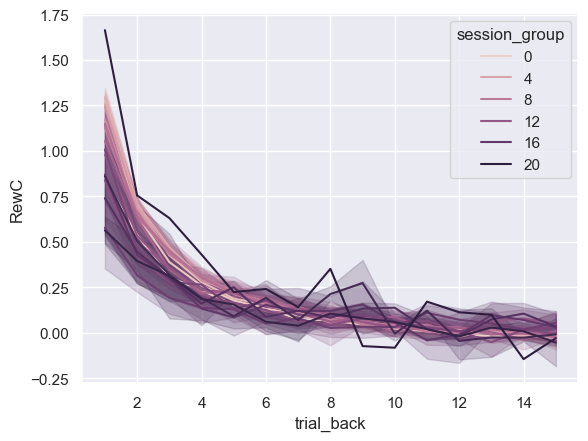

In [83]:
sns.lineplot(final_df, x='trial_back', y='RewC', hue='session_group')

<Axes: xlabel='trial_back', ylabel='UnrC'>

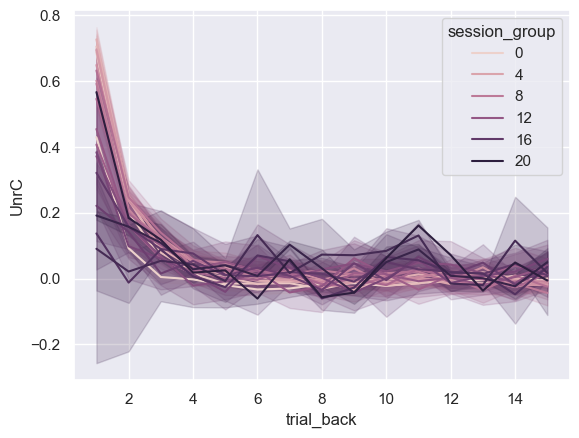

In [84]:
sns.lineplot(final_df, x='trial_back', y='UnrC', hue='session_group')

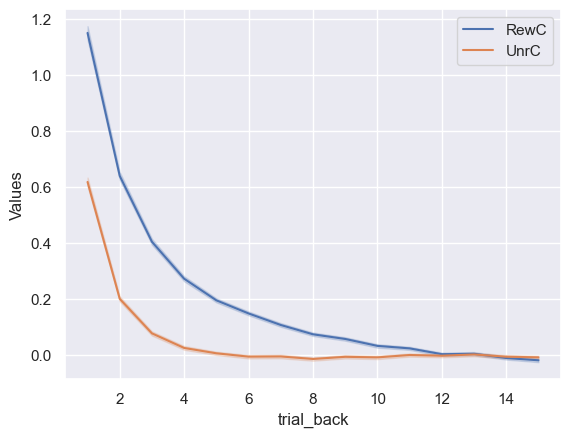

trial back values: [ 1  2  3 ... 13 14 15], 
 RewC values: [ 1.52356609  0.818209    0.57443579 ...  0.06714084  0.04881401
 -0.06559528], 
 UnrC values: [ 0.89043672  0.44114145  0.28319032 ... -0.13775914  0.00536209
 -0.0937279 ]


In [66]:
mean_final_df = final_df.groupby('trial_back', as_index=False)[['RewC', 'UnrC']].mean()

fig, ax = plt.subplots()

sns.lineplot(final_df, x='trial_back', y='RewC', ax=ax, label='RewC')
sns.lineplot(final_df, x='trial_back', y='UnrC', ax=ax, label='UnrC')

ax.set_ylabel('Values')
ax.legend()
plt.show()

x = final_df['trial_back'].values
y = final_df['RewC'].values
y_unrc = final_df['UnrC'].values

print(f'trial back values: {x}, \n RewC values: {y}, \n UnrC values: {y_unrc}')

#### Curve fitting

In [67]:
def exponent_decay(x, a, c, t, asymptote):
    """
    Modified exponential decay function
    
    Params:
    x: input values
    a: amplitude
    c: decay rate 
    t: tau (time constant)
    asymptote: horizontal asymptote
    """ 
    return asymptote + a * np.exp((x + c)/t)

In [68]:

def init_curve_fit(func, x, y):
    """
    Curve fitting with initial guesses and advanced guesses (only pos. y values and log fits)
    """
    def initial_guess_basic():
        a = np.max(np.abs(y)) - np.min(np.abs(y))
        c = 0.1
        t = np.mean(x)
        asymptote = np.median(y)
        return [a, c, t, asymptote]
    
    def initial_guess_advanced():
        try:
            valid_mask = y > 0
            x_log = x[valid_mask]
            y_log = np.log(y[valid_mask])
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_log, y_log)
            
            a = np.exp(intercept)
            c = 0.1
            t = 1 / -slope
            asymptote = np.min(y)
            
            return [a, c, t, asymptote]
        except:
            return initial_guess_basic()
    
    init_strategies = [
        initial_guess_basic,
        initial_guess_advanced
    ]
    
    for strategy in init_strategies:
        try:
            p0 = strategy()
            
            lower_bounds = [0, 0, -np.inf, 0, -np.inf]
            upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf]
            
            popt, pcov = optimize.curve_fit(
                func, x, y, 
                p0=p0,
                bounds=(lower_bounds, upper_bounds),
                method='trf',
                maxfev=10000
            )
            
            y_pred = func(x, *popt)
            r2 = r2_score(y, y_pred)
            
            if np.isfinite(r2) and r2 > -0.1:
                return {
                    'parameters': popt,
                    'covariance': pcov,
                    'r_squared': r2
                }
        
        except Exception as e:
            print(f"Fitting strategy failed: {e}")
    
    raise ValueError("Could not fit the curve with any initialization strategy")

r_value: -0.8671045808916293, p_value: 0.0005475903569436658, std_err: 0.046001328960225366


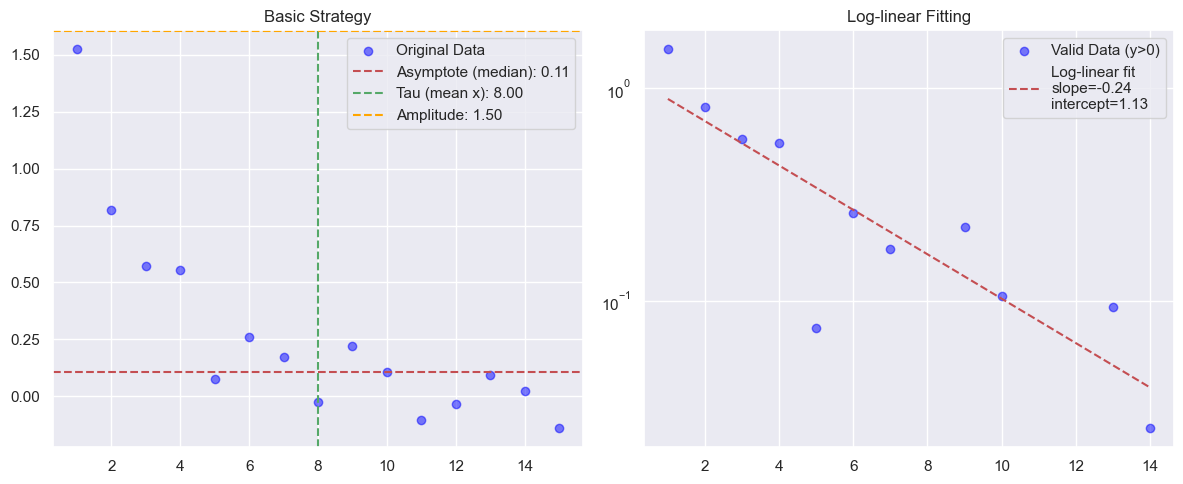

In [69]:
def visualize_initial_guesses(x, y):
    """
    Visualize how initial guesses are computed for curve fitting
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Basic fit
    ax1.scatter(x, y, color='blue', alpha=0.5, label='Original Data')
    
    a = np.max(np.abs(y)) - np.min(np.abs(y))
    asymptote = np.median(y)
    t = np.mean(x)
    
    ax1.axhline(y=asymptote, color='r', linestyle='--', label=f'Asymptote (median): {asymptote:.2f}')
    ax1.axvline(x=t, color='g', linestyle='--', label=f'Tau (mean x): {t:.2f}')
    ax1.axhline(y=asymptote + a, color='orange', linestyle='--', label=f'Amplitude: {a:.2f}')
    
    ax1.set_title('Basic Strategy')
    ax1.legend()
    
    # Log-linear fit
    valid_mask = y > 0
    x_valid = x[valid_mask]
    y_valid = y[valid_mask]
    
    if len(y_valid) > 0:
        y_log = np.log(y_valid)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_valid, y_log)
        
        # Plot original points
        ax2.scatter(x_valid, y_valid, color='blue', alpha=0.5, label='Valid Data (y>0)')
        
        # Plot log-linear fit transformed back to original scale
        x_fit = np.linspace(min(x_valid), max(x_valid), 100)
        y_fit = np.exp(slope * x_fit + intercept)
        ax2.plot(x_fit, y_fit, 'r--', label=f'Log-linear fit\nslope={slope:.2f}\nintercept={np.exp(intercept):.2f}')
        
        ax2.set_yscale('log')
        ax2.set_title('Log-linear Fitting')
        ax2.legend()
        print(f'r_value: {r_value}, p_value: {p_value}, std_err: {std_err}')
    
    plt.tight_layout()
    return fig


x = final_df[final_df['subject_id'] == final_df['subject_id'].iloc[0]]['trial_back'].values
y = final_df[final_df['subject_id'] == final_df['subject_id'].iloc[0]]['RewC'].values

fig = visualize_initial_guesses(x, y)
plt.show()

In [70]:
def analyze_group_fits(df, x_col='trial_back', y_cols=['RewC', 'UnrC']):
    """
    Perform curve fitting for each unique subject-session group
    
    Params:
    - df: pandas DataFrame
    - x_col: column name for x values
    - y_cols: list of columns to fit
    
    Returns:
    - DataFrame with fitted parameters for each group
    """
    # Prepare results storage
    results_list = []
    
    # Unique identifier columns
    group_cols = ['subject_id', 'session_group']
    
    # Group the DataFrame
    grouped = df.groupby(group_cols)
    
    # Iterate through each group
    for name, group in grouped:
        group_results = {
            'subject_id': name[0],
            'session_group': name[1]
        }
        
        # Fit for each y column
        for y_col in y_cols:
            try:
                # Prepare data for fitting
                x = group[x_col].values
                y = group[y_col].values
                
                # Perform curve fitting
                fit_result = init_curve_fit(exponent_decay, x, y)
                
                # Store parameters with column prefix
                for i, param_name in enumerate(['a', 'c', 't', 'asymptote']):
                    group_results[f'{y_col}_{param_name}'] = fit_result['parameters'][i]
                
                # Store R-squared
                group_results[f'{y_col}_r_squared'] = fit_result['r_squared']
            
            except Exception as e:
                print(f"Fitting failed for {name}, {y_col}: {e}")
                # Fill with NaN if fitting fails
                for param in ['a', 'c', 't', 'asymptote', 'r_squared']:
                    group_results[f'{y_col}_{param}'] = np.nan
        
        results_list.append(group_results)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results_list)
    
    return results_df

results_df = analyze_group_fits(final_df)

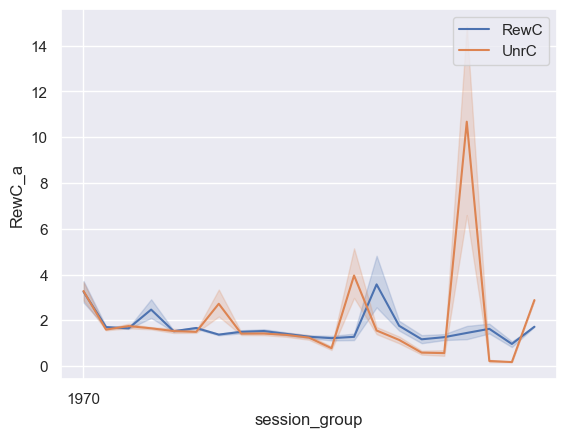

In [72]:
sns.lineplot(results_df, x='session_group', y='RewC_a', label='RewC')
sns.lineplot(results_df, x='session_group', y='UnrC_a', label='UnrC')
plt.legend()

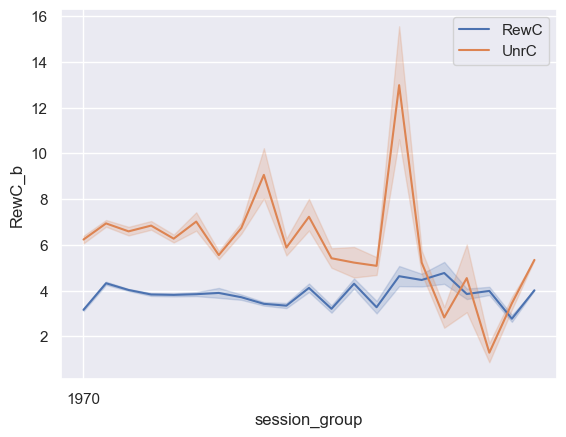

In [73]:
sns.lineplot(results_df, x='session_group', y='RewC_c', label='RewC')
sns.lineplot(results_df, x='session_group', y='UnrC_c', label='UnrC')
plt.legend()

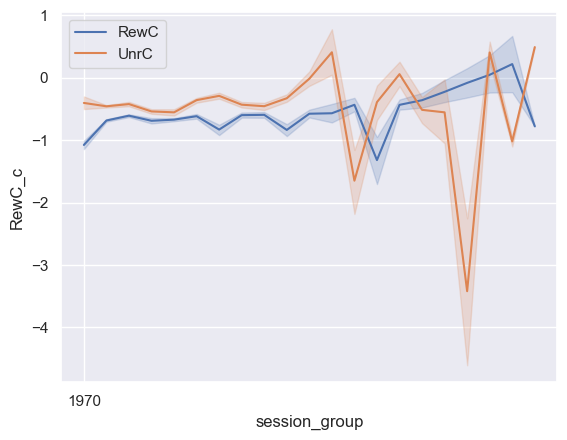

In [74]:
sns.lineplot(results_df, x='session_group', y='RewC_t', label='RewC')
sns.lineplot(results_df, x='session_group', y='UnrC_t', label='UnrC')
plt.legend()

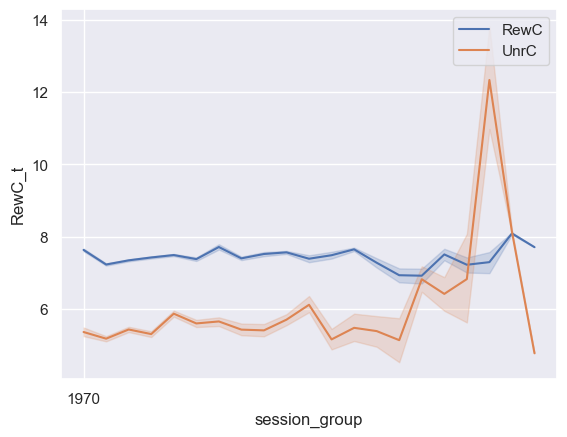

In [75]:
sns.lineplot(results_df, x='session_group', y='RewC_asymptote', label='RewC')
sns.lineplot(results_df, x='session_group', y='UnrC_asymptote', label='UnrC')
plt.legend()

#### Parameter analysis

In [76]:
def calc_subject_kt(subject_data):
    # Select parameters 
    parameter_columns = ['RewC_a', 'RewC_c', 'RewC_t', 'UnrC_a', 'UnrC_c', 'UnrC_t']

    # Find kendall's tau for each parameter
    kt_result = []
    for param in parameter_columns:
        # session_group = x (time), parameter value = y
        tau, p_value = stats.kendalltau(subject_data['session_group'], subject_data[param])
        kt_result.append({
            'parameter': param,
            'tau': tau,
            'p_value': p_value
        })

    return pd.DataFrame(kt_result)

In [77]:
df_sorted = results_df.sort_values(['subject_id', 'session_group'])

In [78]:
subject_kt = df_sorted.groupby('subject_id').apply(calc_subject_kt)

mean_kt = subject_kt.groupby('parameter').agg({
    'tau': ['mean', 'std'],
    'p_value': ['mean', 'std']
}).reset_index()

# Flatten the multi-level column names
mean_kt.columns = ['parameter', 'tau_mean', 'tau_std', 'p_value_mean', 'p_value_std']

print("Kendall's Tau across subjects:")
print(mean_kt)

Kendall's Tau across subjects:
  parameter  tau_mean   tau_std  p_value_mean  p_value_std
0    RewC_a  0.228089  0.535611      0.098546     0.255653
1    RewC_b  0.110350  0.563788      0.102150     0.243789
2    RewC_c  0.087795  0.541066      0.122950     0.277769
3    RewC_t -0.053873  0.535099      0.111453     0.268212
4    UnrC_a  0.035313  0.567875      0.090561     0.241286
5    UnrC_b  0.006986  0.538649      0.123688     0.294853
6    UnrC_c -0.059218  0.551256      0.100356     0.245679
7    UnrC_t  0.135162  0.542291      0.110765     0.273898


/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_60450/3219413078.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subject_kt = df_sorted.groupby('subject_id').apply(calc_subject_kt)
